In [12]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import lmfit
import ray


from bio_optics.water import absorption, attenuation, backscattering, scattering, lee
from bio_optics.atmosphere import downwelling_irradiance
from bio_optics.models import hereon, model
from bio_optics.helper import resampling, utils, owt, indices, plotting

In [2]:
# Define wavelength range and sampling rate
wavelengths=np.arange(400,900)

In [3]:
from bio_optics.water import fluorescence

# global inputs that don't change with fit params
a_md_spec_res = absorption.a_md_spec(wavelengths=wavelengths)
a_bd_spec_res = absorption.a_bd_spec(wavelengths=wavelengths)
a_w_res = resampling.resample_a_w(wavelengths=wavelengths)
a_i_spec_res = resampling.resample_a_i_spec_EnSAD(wavelengths=wavelengths)
b_bw_res = backscattering.b_bw(wavelengths=wavelengths, fresh=False)
b_i_spec_res = resampling.resample_b_i_spec_EnSAD(wavelengths=wavelengths)
da_W_div_dT_res = resampling.resample_da_W_div_dT(wavelengths=wavelengths)
h_C_res = fluorescence.h_C_double(wavelengths=wavelengths, W=0.75)
h_C_phycocyanin_res = fluorescence.h_C(wavelengths=wavelengths, fwhm=20, lambda_C=644)
h_C_phycoerythrin_res =fluorescence.h_C(wavelengths=wavelengths, fwhm=20, lambda_C=573)
omega_d_lambda_0_res = attenuation.omega_d_lambda_0()

E_0_res = resampling.resample_E_0(wavelengths=wavelengths)
a_oz_res = resampling.resample_a_oz(wavelengths=wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths=wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths=wavelengths)
n2_res = resampling.resample_n(wavelengths=wavelengths)

E_dd_res = downwelling_irradiance.E_dd(wavelengths=wavelengths)
E_dsa_res = downwelling_irradiance.E_dsa(wavelengths=wavelengths)
E_dsr_res = downwelling_irradiance.E_dsr(wavelengths=wavelengths)
E_d_res = E_dd_res + E_dsa_res + E_dsr_res

In [4]:
params = lmfit.Parameters()
params.add('C_0', value=0, min=0, max=1000, vary=True) # brown
params.add('C_1', value=1, min=1e-10, max=1000, vary=True) # green
params.add('C_2', value=0, min=0, max=1000, vary=True) # cryptophyte
params.add('C_3', value=0, min=0, max=1000, vary=True) # cyano blue
params.add('C_4', value=0, min=0, max=1000, vary=True) # cyano red
params.add('C_5', value=0, min=0, max=1000, vary=False) # coccolithophores
params.add('C_6', value=0, min=0, max=1000, vary=True) # dinoflagellates
params.add('C_7', value=0, min=0, max=1000, vary=False) # case-1
params.add('C_Y', value=0.1, min=0, max=20, vary=True) 
params.add('C_ism', value=1, min=0, max=1000, vary=True)
params.add('L_fl_lambda0', value=0, min=0, max=0.05, vary=True)
params.add('L_fl_phycocyanin', value=0, min=0, max=0.05, vary=True)
params.add('L_fl_phycoerythrin', value=0, min=0, max=0.05, vary=True)
params.add('b_ratio_C_0', value=0.002, vary=False) # brown
params.add('b_ratio_C_1', value=0.007, vary=False) # green
params.add('b_ratio_C_2', value=0.002, vary=False) # cryptophyte
params.add('b_ratio_C_3', value=0.001, vary=False) # cyano blue
params.add('b_ratio_C_4', value=0.001, vary=False) # cyano red
params.add('b_ratio_C_5', value=0.007, vary=False) # coccolithophores
params.add('b_ratio_C_6', value=0.007, vary=False) # dinoflagellates , chose 0.007 because of smaller cell size
params.add('b_ratio_C_7', value=0.007, vary=False) # case-1
params.add('b_ratio_d', value=0.0216, min=0.021, max=0.0756, vary=True)
params.add('A_md', value=13.4685e-3, vary=False)
params.add('A_bd', value=0.3893e-3, vary=False)
params.add('S_md', value=10.3845e-3, vary=False)
params.add('S_bd', value=15.7621e-3, vary=False)
params.add('S_cdom', value=0.0185, min=0.005, max=0.032, vary=True)
params.add('C_md', value=12.1700e-3, vary=False)
params.add('C_bd', value=0.9994e-3, vary=False)
params.add('K', value=0, min=0, vary=False)
params.add('lambda_0_cdom', value=440, vary=False)
params.add('lambda_0_md', value=550, vary=False)
params.add('lambda_0_bd', value=550, vary=False)
params.add('lambda_0_c_d', value=550, vary=False)
params.add('lambda_0_phy', value=676, vary=False)
params.add('gamma_d', value=0.3835, vary=False)
params.add('x0', value=1, vary=False)
params.add('x1', value=10, vary=False)
params.add('x2', value=-1.3390, min=-1.3390-0.0618, max=-1.3390+0.0618, vary=False)
params.add('A', value=0.0237, vary=False)
params.add('E0', value=1, vary=False)
params.add('E1', value=0.8987, vary=False)
params.add('W', value=0.75, vary=False) 
params.add('fwhm1', value=25, vary=False)
params.add('fwhm2', value=50, vary=False)
params.add('fwhm_phycocyanin', value=20, vary=False)
params.add('fwhm_phycoerythrin', value=20, vary=False)
params.add('lambda_C1', value=685, vary=False)
params.add('lambda_C2', value=730, vary=False)
params.add('lambda_C_phycocyanin', value=644, vary=False)
params.add('lambda_C_phycoerythrin', value=573, vary=False)
params.add('double', value=True, vary=False)
params.add('interpolate', value=True, vary=False)
params.add("Gw0", value=0.05881474, vary=False)
params.add("Gw1", value=0.05062697, vary=False)
params.add("Gp0", value=0.03997009, vary=False)
params.add("Gp1", value=0.1398902, vary=False)
params.add('error_method', value=0, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('theta_view', value=np.radians(1e-10), min=np.radians(1e-10), max=np.radians(90), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('fresh', value=False, vary=False)
params.add('T_W', value=25, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, vary=False) 
params.add('beta', value=0.2606, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('d_r', value=0, min=0, max=0.1, vary=True) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
params.add('offset', value=0, min=-0.1, max=0.1, vary=False)
params.add('fit_surface', value=False, vary=False)

In [30]:
outpath = "E:\Documents\projects\EnsAD\simulations_PhytoGroups\\"
N = 50000
rangeType='BalticSea' #rangeType='NorthSea'
param_DF = pd.read_csv(outpath + "test_simulation_" +rangeType+"_version1_N"+str(int(N))+".txt", header=0, sep='\t')

In [31]:
# Empty arrays to fill with parameters and corresponding spectra
# param_arr = np.zeros((N, 15))
# R_rs_sim = np.zeros((N, len(wavelengths)))

for i in np.arange(N):
    for p in param_DF.columns.values:
        # Change parameters object accordingly.
        params.add(p, value= param_DF[p].values[i])
    
    if i == 0:
        R_rs_sim = hereon.forward(parameters=params, 
                                  wavelengths=wavelengths, 
                                  a_md_spec_res = a_md_spec_res,
                                  a_bd_spec_res = a_bd_spec_res,
                                  a_w_res = a_w_res,
                                  a_i_spec_res = a_i_spec_res,
                                  b_bw_res = b_bw_res, 
                                  b_i_spec_res = b_i_spec_res,
                                  h_C_res = h_C_res,
                                  h_C_phycocyanin_res = h_C_phycocyanin_res,
                                  h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                  da_W_div_dT_res = da_W_div_dT_res,
                                  E_0_res = E_0_res,
                                  a_oz_res = a_oz_res,
                                  a_ox_res = a_ox_res,
                                  a_wv_res = a_wv_res,
                                  E_dd_res = E_dd_res,
                                  E_dsa_res = E_dsa_res,
                                  E_dsr_res = E_dsr_res,
                                  E_d_res = E_d_res,
                                  n2_res = n2_res,
                                  Ls_Ed=[])
    else:
        R_rs_sim = np.vstack((R_rs_sim, hereon.forward(parameters=params, 
                                                       wavelengths=wavelengths, 
                                                       a_md_spec_res = a_md_spec_res,
                                                       a_bd_spec_res = a_bd_spec_res,
                                                       a_w_res = a_w_res,
                                                       a_i_spec_res = a_i_spec_res,
                                                       b_bw_res = b_bw_res, 
                                                       b_i_spec_res = b_i_spec_res,
                                                       h_C_res = h_C_res,
                                                       h_C_phycocyanin_res = h_C_phycocyanin_res,
                                                       h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                                       da_W_div_dT_res = da_W_div_dT_res,
                                                       E_0_res = E_0_res,
                                                       a_oz_res = a_oz_res,
                                                       a_ox_res = a_ox_res,
                                                       a_wv_res = a_wv_res,
                                                       E_dd_res = E_dd_res,
                                                       E_dsa_res = E_dsa_res,
                                                       E_dsr_res = E_dsr_res,
                                                       E_d_res = E_d_res,
                                                       n2_res = n2_res,
                                                       Ls_Ed=[])
                                        ))
        
R_rs_sim = pd.DataFrame(R_rs_sim, columns=wavelengths.astype(str)) 
   

R_rs_sim.to_csv(outpath + "test_Rrs_HEREON_simulation_" +rangeType+"_version1_N"+str(int(N))+".txt", header=0, sep='\t', index=False)

# # Compute a pseudo true-color hex code represenation for each spectrum.
# colors = np.array([plotting.spectrum_to_hex(x, wavelengths) for x in R_rs_arr])

# # Plot simulated spectra.
# plt.plot(wavelengths, R_rs_arr.T)
# plt.xlabel("wavelength [nm]")
# plt.ylabel("$\mathrm{{R}_{rs}\ [sr^{-1}]}$")
# plt.show()

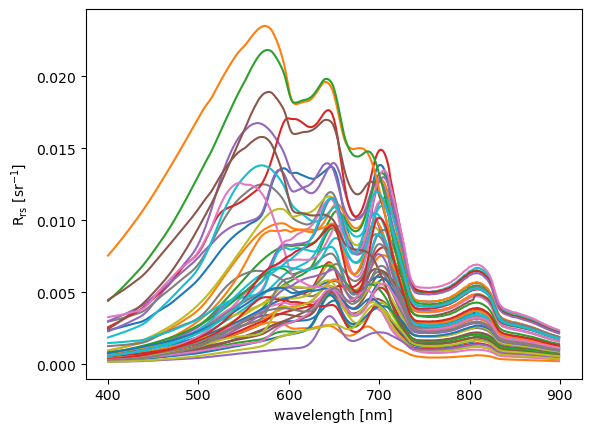

In [32]:
plt.plot(wavelengths, R_rs_sim.iloc[:50,:].T)
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{R}_{rs}\ [sr^{-1}]}$")
plt.show()

In [33]:

# R_rs_arr = R_rs_sim.iloc[:n, :].values
R_rs_arr = R_rs_sim.values
avw = np.array([owt.avw(x, wavelengths) for x in R_rs_arr])
ndi = np.array([indices.ndi(x[wavelengths==665],x[wavelengths==492]) for x in R_rs_arr])

qwip = np.array([owt.qwip(x) for x in avw])
qwip_interp = interp1d(np.sort(avw), qwip[np.argsort(avw)], kind="quadratic", fill_value='extrapolate')

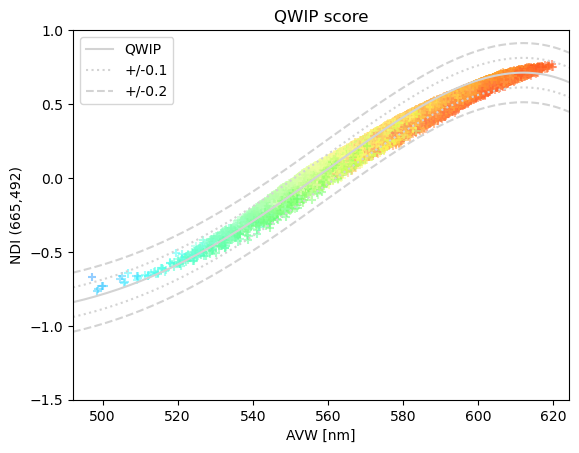

In [34]:
# Compute a pseudo true-color hex code represenation for each spectrum.
colors = np.array([plotting.spectrum_to_hex(x, wavelengths) for x in R_rs_arr])
xrange = np.arange(avw.min()-np.abs(avw.min()*0.01), avw.max()+np.abs(avw.min()*0.01), 1)

plt.scatter(avw, ndi, c=colors, marker='+', alpha=0.5)
plt.plot(xrange, qwip_interp(xrange), c="lightgrey", label="QWIP")
plt.plot(xrange, qwip_interp(xrange)+0.1,":", c="lightgrey", label="+/-0.1")
plt.plot(xrange, qwip_interp(xrange)-0.1,":", c="lightgrey")
plt.plot(xrange, qwip_interp(xrange)+0.2,"--", c="lightgrey", label="+/-0.2")
plt.plot(xrange, qwip_interp(xrange)-0.2,"--", c="lightgrey")
plt.legend()
plt.xlim(xrange.min(), xrange.max())
plt.ylim(-1.5,1)
plt.xlabel('AVW [nm]')
plt.ylabel('NDI (665,492)')
plt.title('QWIP score')
plt.show()

41


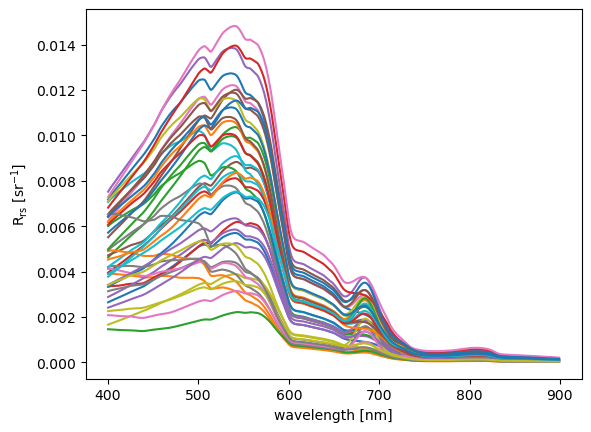

In [24]:
ID = np.array(avw < 520.)
print(np.sum(ID))

plt.plot(wavelengths, R_rs_sim.loc[ID,:].T)
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{R}_{rs}\ [sr^{-1}]}$")
plt.show()

In [25]:
param_DF.loc[ID,:]

,C_0,C_6,C_5,C_7,C_Y,C_ism,L_fl_lambda0,b_ratio_d,S_cdom
3440,0.639568,0.000000,0.000000,0.000000,0.086821,0.849858,0.000496,0.021507,0.013791
3586,0.000000,0.423328,0.000000,0.000000,0.013165,0.207592,0.004054,0.021359,0.012960
3939,0.690796,0.000000,0.000000,0.000000,0.039474,1.814231,0.025368,0.021450,0.017520
5750,2.367314,0.000000,0.000000,0.000000,0.040993,0.930918,0.018443,0.021138,0.012335
6194,0.000000,0.786486,0.000000,0.000000,0.070549,0.973311,0.006185,0.021155,0.013825
6285,1.358700,0.000000,0.000000,0.000000,0.031651,1.573081,0.012237,0.021406,0.010416
6682,0.221680,0.000000,0.000000,0.000000,0.015166,2.160286,0.033970,0.021406,0.018020
8431,0.627625,0.000000,0.000000,0.000000,0.037367,0.432844,0.000571,0.021030,0.015139
8684,0.000000,1.358430,0.000000,0.000000,0.094933,0.509769,0.000262,0.021349,0.018410
8804,0.036116,0.000000,0.000000,0.000000,0.000915,1.234209,0.011934,0.021264,0.019817


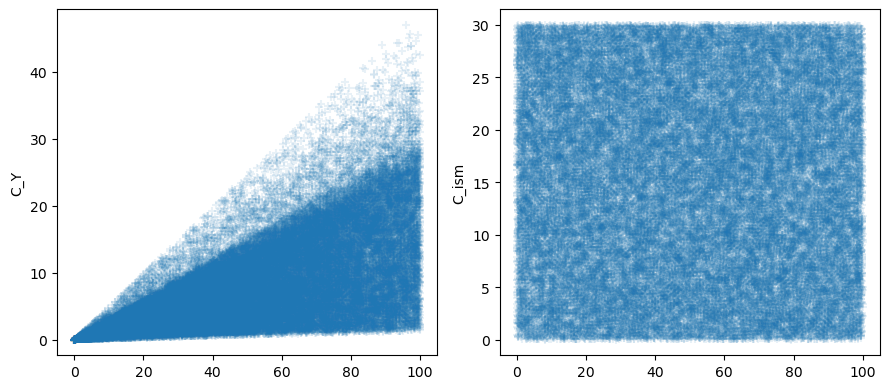

In [29]:
ChlCol = ['C_0', 'C_6', 'C_5', 'C_7']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax[0].scatter(np.sum(param_DF[ChlCol].values, axis=1), param_DF['C_Y'], marker='+', alpha=0.1)
ax[1].scatter(np.sum(param_DF[ChlCol].values, axis=1), param_DF['C_ism'], marker='+', alpha=0.1)
ax[0].set_ylabel('C_Y')
ax[1].set_ylabel('C_ism')
fig.tight_layout()